<a href="https://colab.research.google.com/github/mlccgkpol/C-Plus-Plus/blob/master/ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


In [44]:
n_embed = 10 # no of dimensions
n_hidden = 200 # no of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embed),            generator=g)
W1 = torch.randn((n_embed * block_size), n_hidden, generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #intial tanh should be near zero (refer notes).
W2 = torch.randn((n_hidden, vocab_size),              generator=g) * 0.01 # reduce W2 since logits = h @ W2 and we want logits to be near zero and do not explode initially
b2 = torch.randn(vocab_size,                       generator=g) * 0 ## since we want to be logits to be near zero.
parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True

tensor(0.0088) X_temp mean tensor(0.9886)
tensor(0.0011) y mean tensor(0.6052)


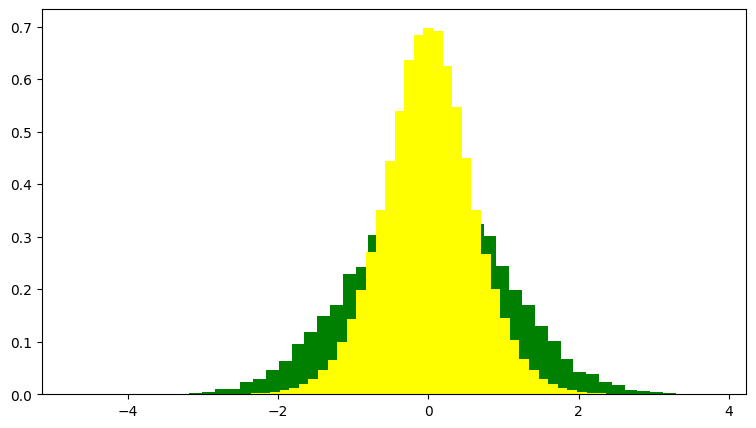

In [56]:
X_temp = torch.randn((1000,10))
w = torch.randn((10,200)) * 0.2
y = X_temp @ w
print(X_temp.mean(),"X_temp mean", X_temp.std())
print(y.mean(),"y mean", y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(X_temp.view(-1).tolist(), 50, density = True, color="green");
plt.subplot(121)
plt.hist(y.view(-1).tolist(), 50, density = True,color="yellow");

You can see the gausian of y is expanding, meaning standard deviation is increasing which we dont want since we want the distribution to be as much gaussian as possible.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini batch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embCat = emb.view(emb.shape[0],-1) #concat the vectors
  hpreact = embCat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [ ]:
plt.plot(lossi)

In [48]:
@torch.no_grad() # this decorator disables gradient tracking.
def split_less(split):
  X,Y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev,Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[X]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} Loss: ', loss.item())
print(split_less("train"))
print(split_less("dev"))

train Loss:  2.0593159198760986
None
dev Loss:  2.125847816467285
None


In [ ]:
## initialization..
# uniform distribution (prob of any character roughly equal to 1/27)
#we want logits to be near zero when model is initialized.
#can we initialize W == 0??
  #


In [ ]:
#4-d example
logits = torch.tensor([0,0,0,0]).float()
probs = torch.softmax(logits,dim = 0)
loss = -probs[2].log()
probs,loss